표준 GAN은 생성자에 대한 latent space input과 생성된 이미지 사이의 복잡한 관계를 파악하고자 학습되지만, 생성되는 이미지의 유형을 제어할 수 없음.

cGAN은 생성자에 의한 조건부 이미지 생성으로 카테고리 별 레이블 혹은 실제 데이터에서 추출한 다른 유형의 정보를 conditioning하여 이미지를 생성.

Conditioning을 통해 생성자의 출력을 제어할 수 있도록 허용하여, 지정된 유형의 이미지를 생성할 수 있도록 한다.

In [ ]:
%load_ext tensorboard
import os
from glob import glob
import time
import random

import IPython.display as display
import matplotlib.pyplot as plt # Matplotlib is used to generate plots of data.
import matplotlib.image as mpimg
import PIL
from PIL import Image
import imageio
import numpy as np # Numpy is an efficient linear algebra library.

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                          Embedding, Flatten, Input, Multiply, Reshape)
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout
from sklearn.preprocessing import OrdinalEncoder
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Configs

In [ ]:
# Experiment paths
EXPERIMENT_ID = "train_cGAN"
MODEL_SAVE_PATH = os.path.join("/content/drive/My Drive/cGAN/train_cGAN", EXPERIMENT_ID)
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)
CHECKPOINT_DIR = os.path.join(MODEL_SAVE_PATH, 'training_checkpoints')

# Data path
DATA_PATH = "/content/drive/My Drive/DCGAN_PRACTICE/datasets/cars/cars_images/"  # DCGAN 실습과 동일한 데이터 사용

# Model parameters
BATCH_SIZE = 64
EPOCHS = 4000
LATENT_DEPTH = 100
IMAGE_SHAPE = [100, 100]
NB_CHANNELS = 3
LR = 1e-4

seed = random.seed(30)

## Data & Data Loader (TF API)

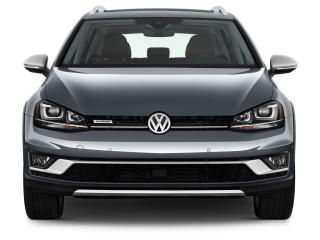

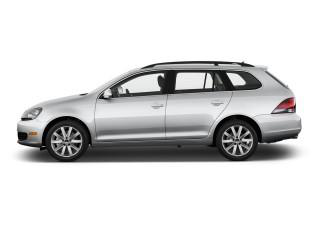

In [ ]:
cars_images_path = list(glob(str(DATA_PATH + '*.jpg')))
for image_path in cars_images_path[:2]:
    display.display(Image.open(str(image_path)))

In [ ]:
images_name = [i.split(DATA_PATH) for i in cars_images_path]
images_name = [x[:][1] for x in images_name]
cars_model = [i.split('_')[0] for i in images_name]

In [ ]:
def unique(list1): 
    list_set = set(list1) 
    unique_list = (list(list_set)) 
    return unique_list

In [ ]:
# 총 20개의 레이블
unique_cars = unique(cars_model)
len(unique_cars)

20

In [ ]:
# Ordinal Encoder를 사용하여 범주형 레이블을 적합한 길이의 정수 배열로 변환
cars_array = np.reshape(cars_model,(-1, 1))
encoder = OrdinalEncoder()
encoder.fit(cars_array)
label_encoded = encoder.transform(cars_array)

In [ ]:
print(label_encoded.shape)
print(label_encoded)

(8960, 1)
[[17.]
 [17.]
 [17.]
 ...
 [ 3.]
 [ 3.]
 [ 3.]]


In [ ]:
# Label도 같이 처리하는 것에 주의
@tf.function
def preprocessing_data(path, labels):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SHAPE[0],IMAGE_SHAPE[1]])
    image = image / 255.0
    return image, labels

def dataloader(paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.shuffle(10* BATCH_SIZE)
    dataset = dataset.map(preprocessing_data)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1)
    return dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


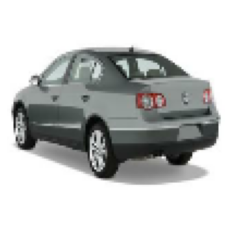

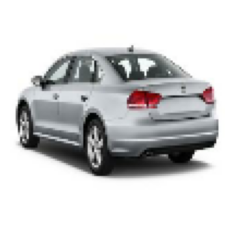

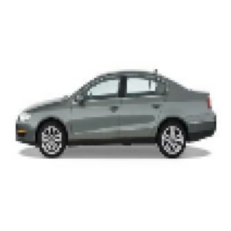

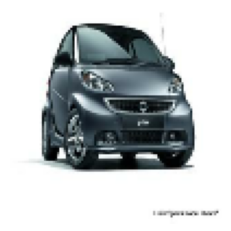

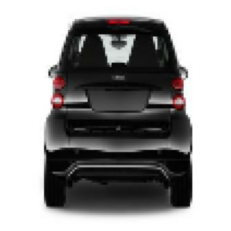

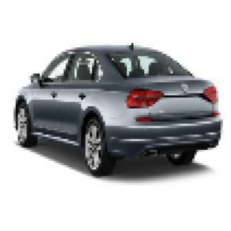

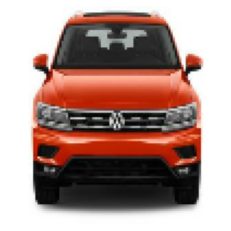

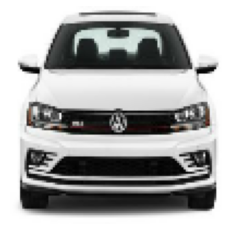

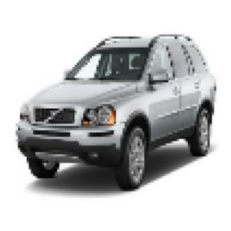

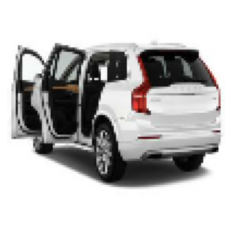

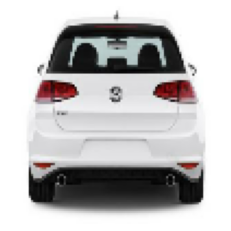

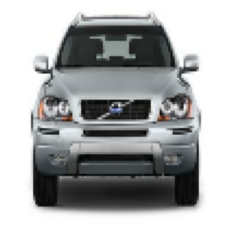

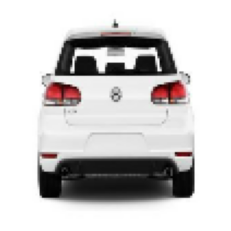

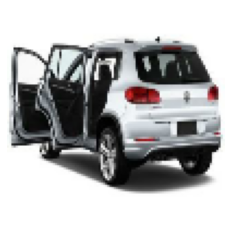

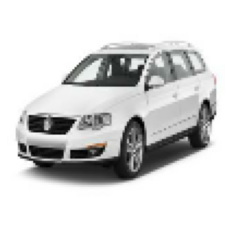

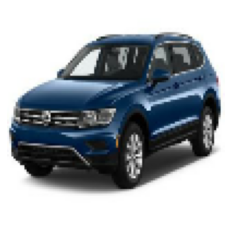

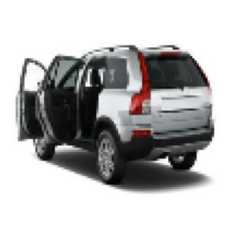

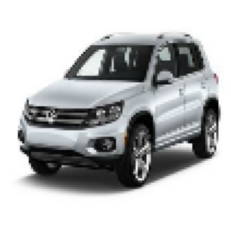

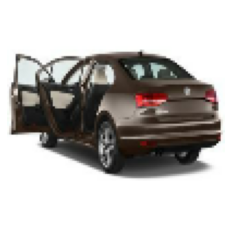

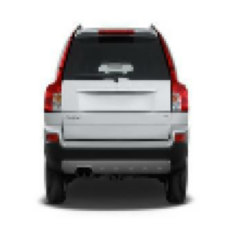

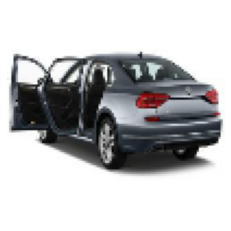

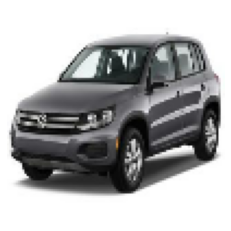

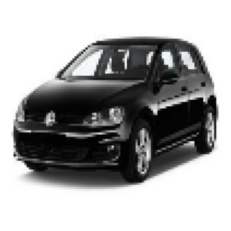

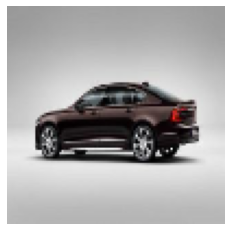

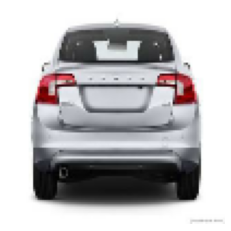

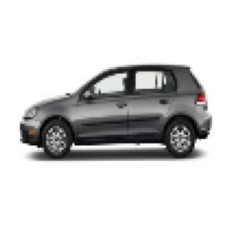

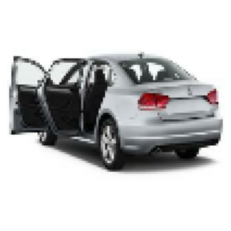

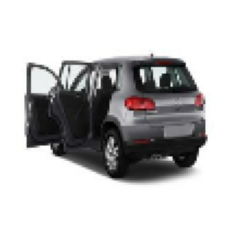

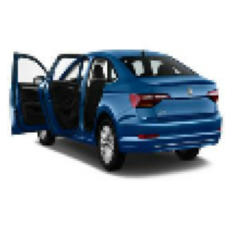

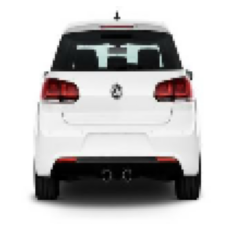

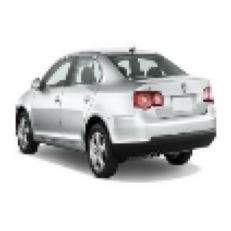

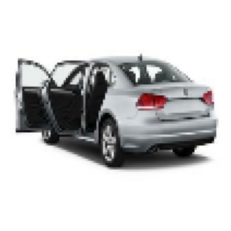

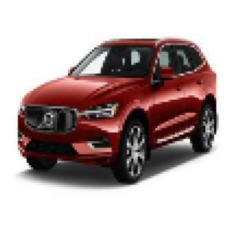

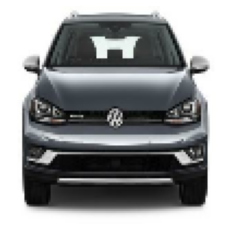

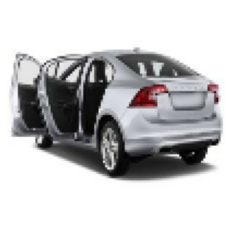

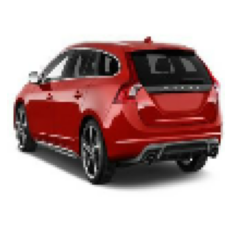

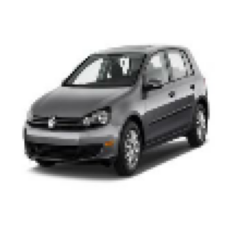

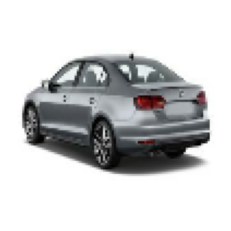

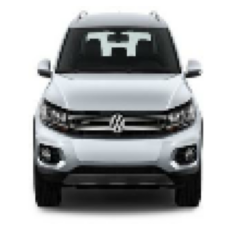

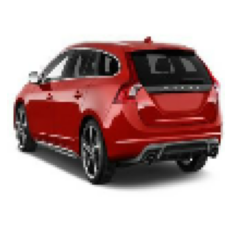

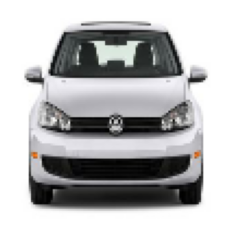

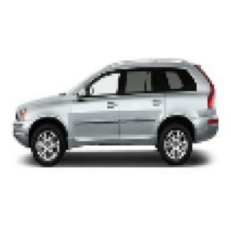

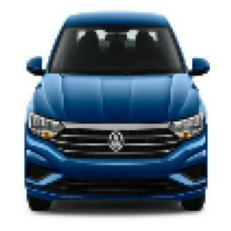

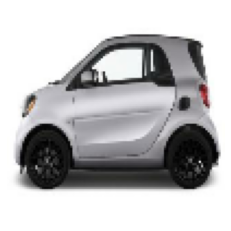

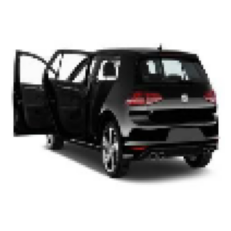

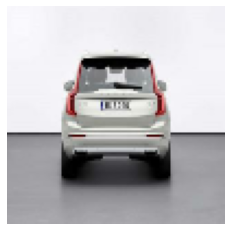

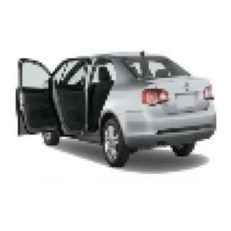

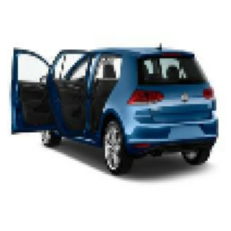

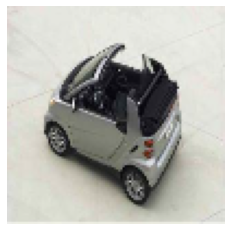

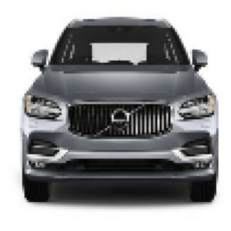

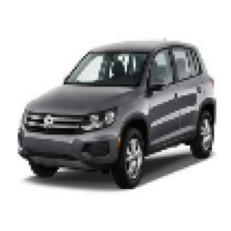

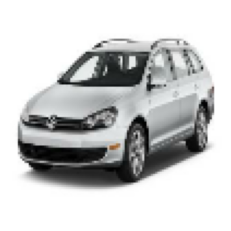

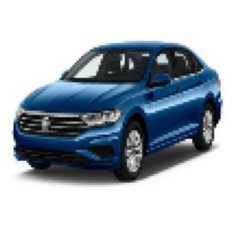

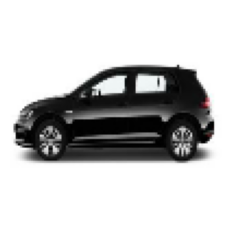

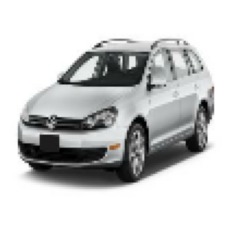

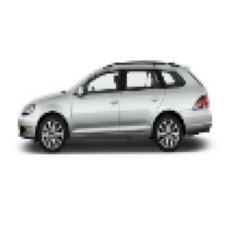

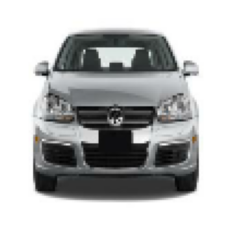

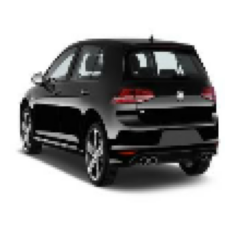

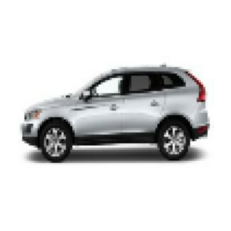

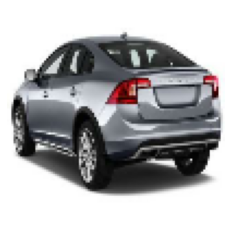

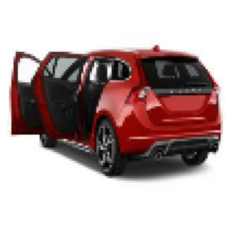

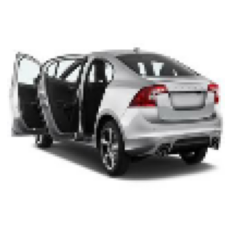

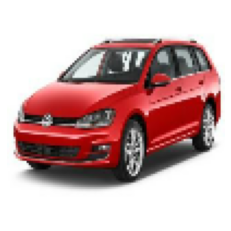

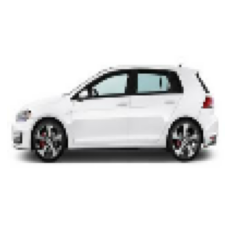

In [ ]:
# 이미지와 인코딩된 레이블을 같이 불러옴
dataset = dataloader(cars_images_path, label_encoded)
for batch, labels in dataset.take(1):
    for img, label in zip(batch, labels):
        img_np = img.numpy()
        plt.figure()
        plt.axis('off')
        plt.imshow((img_np-img_np.min())/(img_np.max()-img_np.min()))

## Modeling

![image](https://user-images.githubusercontent.com/44194558/138832886-81372ebb-87f5-41e6-ae5e-57268285f252.png)


**생성자** : 랜덤 노이즈, 클래스 레이블 벡터를 입력으로 받음

**판별자** : 입력 이미지-레이블의 pair를 입력으로 받아, 이미지의 realness에 대한 판단 여부와 이미지와 레이블의 일치 여부에 대한 예측 출력


Keras Function API를 통해 복수의 입력/출력 모델을 정의

### Generator

In [ ]:
def make_generator_model(latent_dim, n_classes=20):  
    
    # Label Input
    # Embedding for categorical input
    label = Input(shape=(1, ))
    label_embedding = Embedding(n_classes, 50)(label)  # 크기 50의 embedding layer 통과 -> 데이터셋의 20개 레이블 각각이 생성자에 투영되어 서로 다른 50 element vector representation 학습
    label_embedding = Dense(25 * 25)(label_embedding)
    label_embedding = Reshape((25, 25, 1))(label_embedding)  # (None, 25, 25, 1)

    # Random Noise Input
    input_noise = Input(shape=(latent_dim, ))
    layer = Dense(128 * 25 * 25)(input_noise)
    layer = ReLU()(layer)
    layer = Reshape((25, 25, 128))(layer)  # (None, 25, 25, 128)

    # Label, Noise Input 결합
    merge = Concatenate()([layer, label_embedding])  # (None, 25, 25, 128+1) 

    layer = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(merge)
    layer = ReLU()(layer)

    layer = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(layer)
    layer = ReLU()(layer)

    output_layer = Conv2DTranspose(3, (5, 5), strides=(2, 2), activation='sigmoid', padding='same', use_bias=False)(layer)  # (None, 100, 100, 3)
    
    # Label, Noise를 입력으로 받아 (100, 100, 3)의 이미지를 생성
    model = Model([input_noise, label], output_layer)
    model.summary()

    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 80000)        8080000     input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        1000        input_1[0][0]                    
______________________________________________________________________________________________

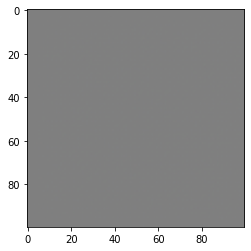

In [ ]:
generator = make_generator_model(latent_dim=100)
noise = tf.random.normal([1, LATENT_DEPTH])
generated_image = generator([noise, label_encoded[5]], training=True)

plt.imshow(generated_image[0, :, :, :], cmap='gray')

## Discriminator

In [ ]:
def define_discriminator(in_shape=(100, 100, 3), n_classes=20):
    
    # Label Input
    in_label = Input(shape=(1,))
    label_embedding = Embedding(n_classes, 50)(in_label)
    
    # 이미지의 차원 만큼 scale up
    n_nodes = in_shape[0] * in_shape[1]
    label_embedding = Dense(n_nodes)(label_embedding)
    label_embedding = Reshape((in_shape[0], in_shape[1], 1))(label_embedding)  # (None, 100, 100, 1)

    # Image Input
    in_image = Input(shape=in_shape)  # (None, 100, 100, 3)

    # Concat
    merge = Concatenate()([in_image, label_embedding])  # (None, 100, 100, 3+1)

    # downsample
    layer = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(merge)
    layer = LeakyReLU(alpha=0.2)(layer)

    layer = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(layer)
    layer = LeakyReLU(alpha=0.2)(layer)

    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)

    output_layer = Dense(1)(layer)

    model = Model([in_image, in_label], output_layer)
    model.summary()

    return model

In [ ]:
discriminator = define_discriminator()
decision = discriminator([generated_image, label_encoded[5]])
print (decision)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        1000        input_3[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1, 10000)     510000      embedding_1[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 100, 100, 3) 0                                            
____________________________________________________________________________________________

## Training Process

### Loss and Optimization

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(lr=LR)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=LR)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Experiment Utils

In [ ]:
def summary(name_data_dict,
            step=None,
            types=['mean', 'std', 'max', 'min', 'sparsity', 'histogram'],
            historgram_buckets=None,
            name='summary'):
    """Summary.
    Examples
    --------
    >>> summary({'a': data_a, 'b': data_b})
    """
    def _summary(name, data):
        if data.shape == ():
            tf.summary.scalar(name, data, step=step)
        else:
            if 'mean' in types:
                tf.summary.scalar(name + '-mean', tf.math.reduce_mean(data), step=step)
            if 'std' in types:
                tf.summary.scalar(name + '-std', tf.math.reduce_std(data), step=step)
            if 'max' in types:
                tf.summary.scalar(name + '-max', tf.math.reduce_max(data), step=step)
            if 'min' in types:
                tf.summary.scalar(name + '-min', tf.math.reduce_min(data), step=step)
            if 'sparsity' in types:
                tf.summary.scalar(name + '-sparsity', tf.math.zero_fraction(data), step=step)
            if 'histogram' in types:
                tf.summary.histogram(name, data, step=step, buckets=historgram_buckets)

    with tf.name_scope(name):
        for name, data in name_data_dict.items():
            _summary(name, data)

In [ ]:
train_summary_writer = tf.summary.create_file_writer(os.path.join(MODEL_SAVE_PATH, 'summaries', 'train'))
checkpoint_prefix = os.path.join(CHECKPOINT_DIR, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def generate_and_save_images(model, label, epoch):
    
    plt.figure(figsize=(15,10))

    for i in range(4):
        noise = tf.random.normal([1,100])
        images = model([noise, label[0]], training=False)
        print(label[0])
        image = images[0, :, :, :]
        image = np.reshape(image, [100, 100, 3])

        plt.subplot(1, 4, i+1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.title("Randomly Generated Images")

    plt.tight_layout()  
    plt.savefig(os.path.join(MODEL_SAVE_PATH,'image_at_epoch_{:02d}.png'.format(epoch)))
    plt.show()

## Model Training

In [ ]:
@tf.function
def train_step(images, label):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DEPTH])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, label], training=True)

        real_output = discriminator([images, label], training=True)
        fake_output = discriminator([generated_images, label], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return {'Generator loss': gen_loss,
            'Discriminator loss': disc_loss}

In [ ]:
def train(dataset, epochs):
    with train_summary_writer.as_default():
        with tf.summary.record_if(True):
            for epoch in range(epochs):
                start = time.time()

                for image_batch, labels in dataset:
                    loss_dict = train_step(image_batch, labels)
                summary(loss_dict, step=generator_optimizer.iterations, name='losses')
            
                if (epoch + 1) % 15 == 0:
                    checkpoint.save(file_prefix = checkpoint_prefix)
                    display.clear_output(wait=True)
                    generate_and_save_images(generator, labels, epoch + 1)

                print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    display.clear_output(wait=True)

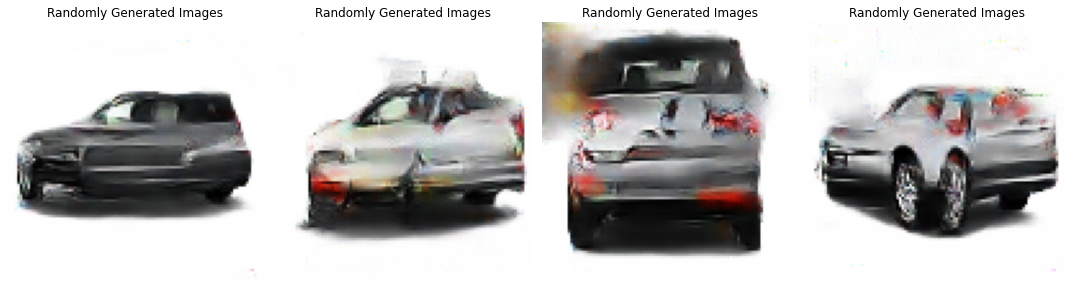

Time for epoch 1230 is 12.311027526855469 sec
Time for epoch 1231 is 11.897424221038818 sec
Time for epoch 1232 is 11.473252296447754 sec
Time for epoch 1233 is 11.493811130523682 sec
Time for epoch 1234 is 11.33588695526123 sec
Time for epoch 1235 is 11.249661445617676 sec
Time for epoch 1236 is 11.353726387023926 sec
Time for epoch 1237 is 11.647827386856079 sec
Time for epoch 1238 is 11.45288634300232 sec


In [ ]:
train(dataset, EPOCHS)

In [ ]:
%tensorboard --logdir='/content/drive/My Drive/cGAN/results/train_cGAN/'

In [ ]:
anim_file = 'cgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob(os.path.join(MODEL_SAVE_PATH, 'image*.png'))
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)